# **MANDACARU.DEV - TIME 09 - CLASSIFICADOR DE SENTIMENTOS DE NOTÍCIAS - PERSPECTIVA ANALÍTICA**

---
Akyla Aquino, Cauã Braga, Evandro Martins, Geovana Rodrigues, Yann Lucca.

---



In [1]:
#IMPORTAÇÃO DAS BIBLIOTECAS NECESSÁRIAS:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **1. ANÁLISE DE SENTIMENTOS**

---
Este projeto utiliza técnicas de processamento de linguagem natural (PLN) para classificar os sentimentos de trechos de notícias.


# **2. DATASET**


---

A base de dados utilizada foi disponibilizada pela organização do Mandacaru.Dev e contém colunas referentes às sentenças a serem analisadas (coluna Sentence) e os sentimentos associados a essas sentenças (coluna Sentiment), sendo classificados em positivos, negativos ou neutros. Segue uma amostra de 10 elementos do DataSet:

In [2]:
#CARREGAMENTO DO DATASET EM FORMA DE DATAFRAME E EXIBIÇÃO OS 10 PRIMEIROS ELEMENTOS:
dataset = pd.read_csv("/content/data.csv")
dataset.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


## **3. PRÉ-PROCESSAMENTO**

---
As técnicas de remoção de caracteres especiais, remoção de StopWords, Lematização, Normalização, remoção de links e Tokenização foram utilizadas para o processamento textual da coluna "Sentence". O pré-processamento foi realizando utilizando a GPU do Google Colab contendo todas as 5842 linhas do DataSet. O algoritmo de pré-processamento está documentado a seguir:



In [3]:
#EXTRAÇÃO DO TIPO DE DADOS DO DATASET:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [4]:
#SALVANDO A COLUNA "SENTENCE" EM UMA LISTA:
noticia = dataset.Sentence

#SALVANDO A COLUNA "SENTIMENT" EM UMA LISTA:
sentimento = dataset.Sentiment

In [5]:
#REMOÇÃO DE LINHAS REPETIDAS DO DATASET:
boole = noticia.duplicated()

noticia_nao_repetida = []
sentimento_nao_repetido = []

for i in range(len(noticia)):
  if not boole[i]:
    noticia_nao_repetida.append(noticia[i])
    sentimento_nao_repetido.append(sentimento[i])

In [6]:
#REMOÇÃO DE LINKS DA COLUNA "SENTENCE" DO DATASET:
def remove_links(sentence):
    link_padrao = re.compile(r'https?://\S+|www\.\S+')
    sentenca_sem_links = re.sub(link_padrao, '', sentence)

    return sentenca_sem_links

# Exemplo de uso
noticia_sem_links = [remove_links(sentenca) for sentenca in noticia_nao_repetida]

In [7]:
#TOKENIZAÇÃO DA COLUNA "SENTENCE":
noticia_tokens = [nltk.word_tokenize(noticia) for noticia in noticia_sem_links]

#NORMALIZAÇÃO DA COLUNA "SENTENCE":
noticia_normalizado = [None]*len(noticia_tokens)
for i in range (len(noticia_tokens)):
  noticia_normalizado[i] = [word.lower() for word in noticia_tokens[i] if word.isalnum()]

#NORMALIZAÇÃO DA COLUNA "SENTIMENT":
sentimento_normalizado = [word.lower() for word in sentimento_nao_repetido if word.isalpha]

In [8]:
#REMOÇÃO DE STOPWORDS DA COLUNA "SENTENCE":
noticia_filtrado = [None]*len(noticia_normalizado)
stop_words = set(stopwords.words('english'))
for i in range (len(noticia_normalizado)):
  noticia_filtrado[i] = [token.lower() for token in noticia_normalizado[i] if not token in stop_words]

In [9]:
#LEMATIZAÇÃO TEXTUAL DA COLUNA "SENTENCE":
lematizador = WordNetLemmatizer()
noticia_lematizado = [None]*len(noticia_filtrado)
for i in range (len(noticia_tokens)):
  noticia_lematizado[i] = [lematizador.lemmatize(token) for token in noticia_filtrado[i]]

In [10]:
#ARMAZENAMENTO DOS DADOS TRATADOS EM UM NOVO DATASET:
novo_dataset = pd.DataFrame({'Sentence':noticia_lematizado, 'Sentiment':sentimento_normalizado})

#AMOSTRA DOS DADOS TRATADOS:
novo_dataset.head(10)

,Sentence,Sentiment
0,"[geosolutions, technology, leverage, benefon, ...",positive
1,"[esi, low, bk, real, possibility]",negative
2,"[last, quarter, 2010, componenta, net, sale, d...",positive
3,"[according, chamber, commerce, major, construc...",neutral
4,"[swedish, buyout, firm, sold, remaining, perce...",neutral
5,"[spy, would, surprised, see, green, close]",positive
6,"[shell, 70, billion, bg, deal, meet, sharehold...",negative
7,"[ssh, communication, security, corp, stock, ex...",negative
8,"[kone, net, sale, rose, 14, first, nine, month...",positive
9,"[stockmann, department, store, total, floor, s...",neutral


# **4. ANÁLISE EXPLORATÓRIA**

---
A respeito da análise exploratória dos dados do dataset fornecido, as técnicas utilizadas a fim de extrair informações relevantes que indicam a tendência estatística dos dados em questão incluem UnderSampling, nuvens de palavras para cada classe e plotagem de gráficos estatísticos, dos quais estão inclusos o gráfico de barras n-gram e o histograma. Segue o algoritmo referente:


In [13]:
#PROCESSO DE UNDERSAMPLING:

#CONTAGEM DAS INSTÂNCIAS DAS CLASSES DA COLUNA "SENTIMENT":
counts = novo_dataset['Sentiment'].value_counts()

#IDENTIFICAÇÃO DA CLASSE COM O MENOR NÚMERO DE INSTÂNCIAS:
sentimento_minimo = counts.idxmin()

#INICIALIZAÇÃO DE UM DATAFRAME VAZIO PARA ARMAZENAR OS SUBCONJUNTOS BALANCEADOS:
dfs_balanceados = []

#ITERAÇÃO SOBRE CADA CLASSE:
for sentimento in counts.index:
    #DIVISÃO DO DATAFRAME EM SUBCONJUNTOS POR CLASSE:
    df_classe = novo_dataset[novo_dataset['Sentiment'] == sentimento]

    #REALIZAÇÃO DE UNDERSAMPLING CASO A CLASSE EM QUESTÃO NÃO SEJA A COM O MENOR NÚMERO DE INSTÂNCIAS:
    if sentimento != sentimento_minimo:
        df_classe_downsampled = resample(df_classe, replace=False, n_samples=counts[sentimento_minimo], random_state=42)
        dfs_balanceados.append(df_classe_downsampled)
    else:
        #INCLUSÃO DA CLASSE, CASO SEJA A COM O MENOR NÚMERO DE INSTÂNCIAS, NO DATAFRAME BALANCEADO:
        dfs_balanceados.append(df_classe)

#COMBINAÇÃO DOS SUBCONJUNTOS BALANCEADOS:
df_balanceado = pd.concat(dfs_balanceados)

#EXIBIÇÃO DO DATAFRAME BALANCEADO:
print(df_balanceado)

                                               Sentence Sentiment
866   [customer, include, company, energy, process, ...   neutral
2643     [investment, worth, approximately, eur, 100mn]   neutral
4371  [honkarakenne, also, decided, yesterday, sell,...   neutral
2920  [company, said, offshore, segment, represented...   neutral
2016  [vaisala, present, weather, detector, measure,...   neutral
...                                                 ...       ...
5296                    [fb, hitting, everything, twtr]  negative
5298                                  [bobe, premarket]  negative
5303                                   [acad, 2, today]  negative
5313         [sbux, pm, db, downgrade, pt, cut, 70, 64]  negative
5317  [hsbc, say, unit, book, 585, million, charge, ...  negative

[1776 rows x 2 columns]


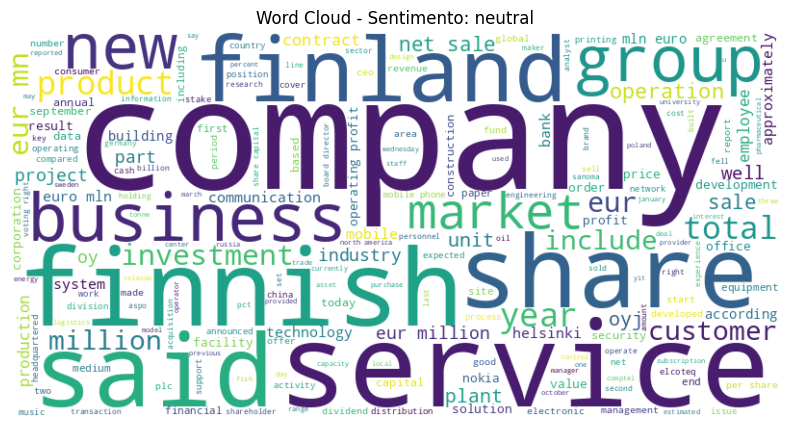

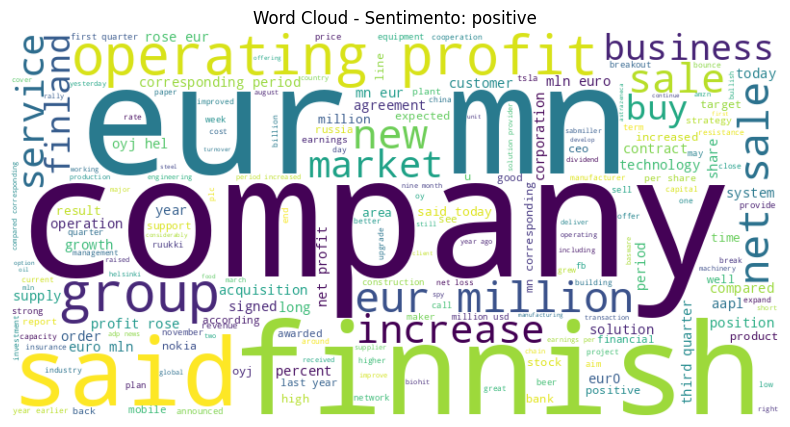

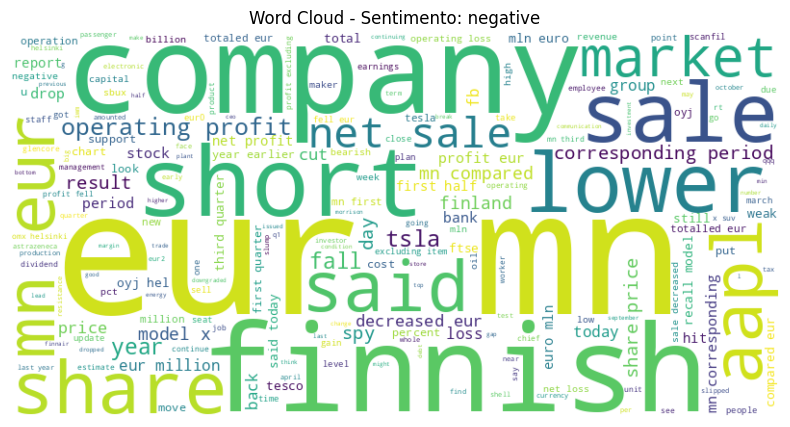

In [14]:
#PLOTAGEM DE NUVENS DE PALAVRAS:

#JUNÇÃO DAS PALAVRAS TOKENIZADAS EM UMA ÚNICA STRING PARA CADA CLASSE:
texto_sentimento = {}
for sentimento in df_balanceado['Sentiment'].unique():
    tokenized_news = df_balanceado[df_balanceado['Sentiment'] == sentimento]['Sentence'].values
    texto_sentimento[sentimento] = ' '.join([' '.join(tokens) for tokens in tokenized_news])

#CRIAÇÃO E EXIBIÇÃO DA NUVEM DE PALAVRAS PARA CADA CLASSE DE SENTIMENTO:
for sentimento, texto in texto_sentimento.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - Sentimento: {sentimento}')
    plt.axis('off')
    plt.show()